<a href="https://colab.research.google.com/github/RoxieCardonax/LeafIdentification/blob/main/CM_VGG16_01_SPECIE_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0. Install Dependencies and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow opencv-python matplotlib

In [3]:
!pip install scikit-learn

In [4]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [5]:
!pip install keras

In [6]:
import tensorflow as tf
import os

In [7]:
#Only use 50% of GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 29 09:47:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    50W / 400W |    677MiB / 40960MiB |      6%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.1. Remove Dodgy Image

In [8]:
import cv2
import imghdr # allows to check file extensions
from matplotlib import pyplot as plt

In [9]:
data_dir = '/content/drive/MyDrive/leafspecies/data' #variable to hold path to data directory

In [10]:
image_extensions = ['jpeg','jpg', 'bmp', 'png'] #list of standard image file extensions

In [11]:
all_files = os.listdir(data_dir)

In [12]:
# for loop - looping through directory and then every image to check if they can be used by cv2 and imghdr if not then they are removed
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #not a valid image
            tip = imghdr.what(image_path) #not a valid image extension
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image /content/drive/MyDrive/leafspecies/data/Basil (P8)/healthy
Issue with image /content/drive/MyDrive/leafspecies/data/Gauva (P3)/healthy
Issue with image /content/drive/MyDrive/leafspecies/data/Gauva (P3)/diseased
Issue with image /content/drive/MyDrive/leafspecies/data/Jatropha (P6)/healthy
Issue with image /content/drive/MyDrive/leafspecies/data/Jatropha (P6)/diseased
Issue with image /content/drive/MyDrive/leafspecies/data/Alstonia Scholaris (P2)/diseased
Issue with image /content/drive/MyDrive/leafspecies/data/Alstonia Scholaris (P2)/healthy
Issue with image /content/drive/MyDrive/leafspecies/data/Mango (P0)/healthy
Issue with image /content/drive/MyDrive/leafspecies/data/Mango (P0)/diseased
Issue with image /content/drive/MyDrive/leafspecies/data/Arjun (P1)/healthy
Issue with image /content/drive/MyDrive/leafspecies/data/Arjun (P1)/diseased
Issue with image /content/drive/MyDrive/leafspecies/data/Bael (P4)/diseased
Issue with image /content/drive/MyDrive/leafspecies

In [13]:
#How many classes are there?
num_classes = 0

#Iterate Directory
for path in os.listdir(data_dir):
    num_classes += 1
print ('File count:', num_classes)


File count: 12


In [14]:
print(all_files)

['Basil (P8)', 'Gauva (P3)', 'Jatropha (P6)', 'Alstonia Scholaris (P2)', 'Mango (P0)', 'Arjun (P1)', 'Bael (P4)', 'Jamun (P5)', 'Lemon (P10)', 'Chinar (P11)', 'Pomegranate (P9)', 'Pongamia Pinnata (P7)']


# 2.0. Load Data

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
#Build the data pipeline
data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/leafspecies/data',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 4503 files belonging to 12 classes.


In [17]:
# Access the class names
class_names = data.class_names

In [18]:
data_iterator = data.as_numpy_iterator() #access the generator from data pipeline - allowing us to loop through data pipeline

In [19]:
batch = data_iterator.next() #accessing the data piepline itself

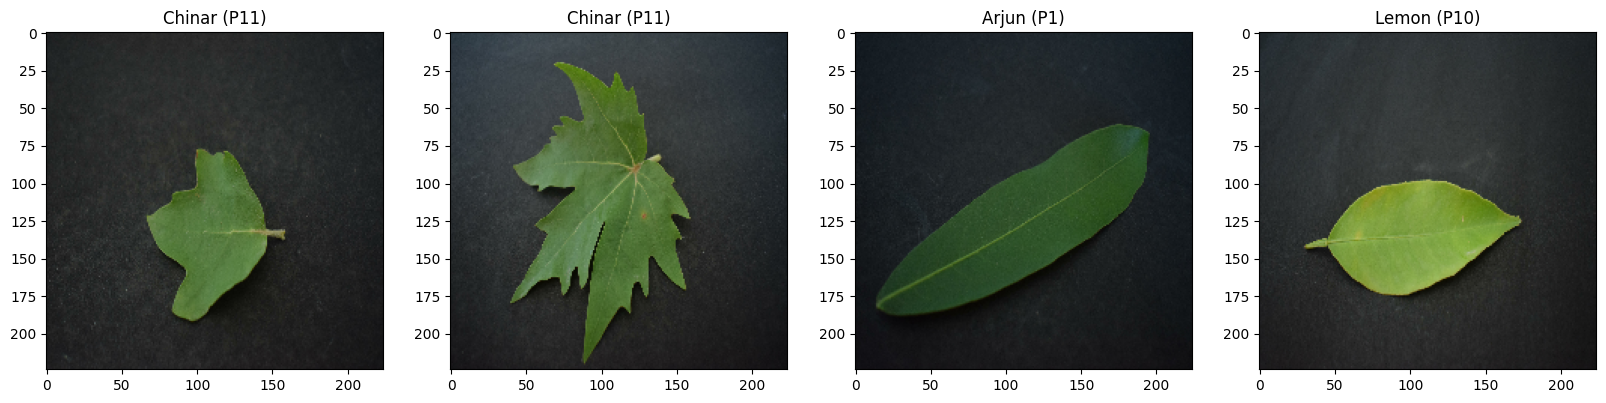

In [20]:
# Assuming batch[1][idx] contains one-hot encoded class labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float) / 255.0)

    # Use np.argmax to find the class label
    class_label_index = np.argmax(batch[1][idx])

    # Use the class label index to access the class name
    ax[idx].set_title(class_names[class_label_index])

# 3.0. Pre-Processing Data

## 3.1. Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y)) #map - applies a particular transformation as data is being preprocessed by the data pipeline... x = images, y = target values

In [22]:
scaled_iterator=data.as_numpy_iterator()

In [23]:
batch = scaled_iterator.next()

In [24]:
#CHECK FOR BATCH MAX AND MIN 0 - 1
#batch [0].min()
batch [0].max()

0.8720298

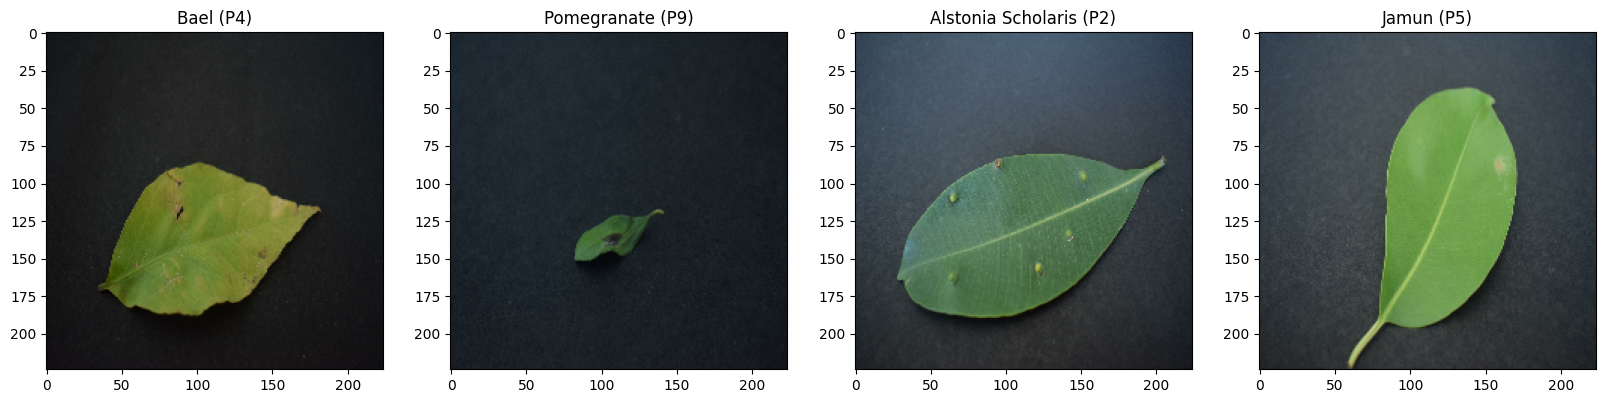

In [25]:
#CHECK IF IMAGES ARE LOADED AND SCALED
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float))

    # Use np.argmax to find the class label
    class_label_index = np.argmax(batch[1][idx])

    # Use the class label index to access the class name
    ax[idx].set_title(class_names[class_label_index])

## 3.2. Split Data

In [26]:
#Partitian Allocation
train_size = np.array((len(data)*.7)) #training will be 70% of data
val_size = np.array((len(data)*.2)) #20% for validation
test_size = np.array((len(data)*.1+1)) #10% testing + 1 because the data is an uneven number

In [27]:
#CHECK that it is equal to length
train_size+val_size+test_size

142.0

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [29]:
len(test)

15

# 4.0. Deep Learning Model

## 4.1. Load VGG16 Model

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [31]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [32]:
# Set VGG16 layers to be non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Add custom classification layers on top of VGG16
model = Sequential()

# Add the pre-trained VGG16 layers to the new model
model.add(base_model)

# Flatten the output of VGG16
model.add(Flatten())

# Add one or more dense layers for classification (adjust the number of neurons as needed)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adjust the dropout rate as needed
model.add(Dense(num_classes, activation='softmax'))  # 'num_classes' is the number of leaf species

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 21140556 (80.64 MB)
Trainable params: 6425868 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [34]:
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 4.2. Train

In [35]:
from tensorflow.keras.callbacks import TensorBoard

In [36]:
logdir='logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [39]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping]) #fit is the training function

Epoch 1/50
98/98 [==============================] - 359s 4s/step - loss: 1.7146 - accuracy: 0.4939 - val_loss: 0.8285 - val_accuracy: 0.7757
Epoch 2/50
98/98 [==============================] - 78s 775ms/step - loss: 1.0070 - accuracy: 0.6524 - val_loss: 0.6624 - val_accuracy: 0.8025
Epoch 3/50
98/98 [==============================] - 78s 775ms/step - loss: 0.8190 - accuracy: 0.7258 - val_loss: 0.5352 - val_accuracy: 0.8527
Epoch 4/50
98/98 [==============================] - 78s 774ms/step - loss: 0.7336 - accuracy: 0.7577 - val_loss: 0.4171 - val_accuracy: 0.8828
Epoch 5/50
98/98 [==============================] - 78s 776ms/step - loss: 0.6685 - accuracy: 0.7800 - val_loss: 0.3768 - val_accuracy: 0.8940
Epoch 6/50
98/98 [==============================] - 79s 783ms/step - loss: 0.6108 - accuracy: 0.7781 - val_loss: 0.3474 - val_accuracy: 0.8996
Epoch 7/50
98/98 [==============================] - 78s 776ms/step - loss: 0.5480 - accuracy: 0.8042 - val_loss: 0.3291 - val_accuracy: 0.9018
E

## 4.3. Plot Performance

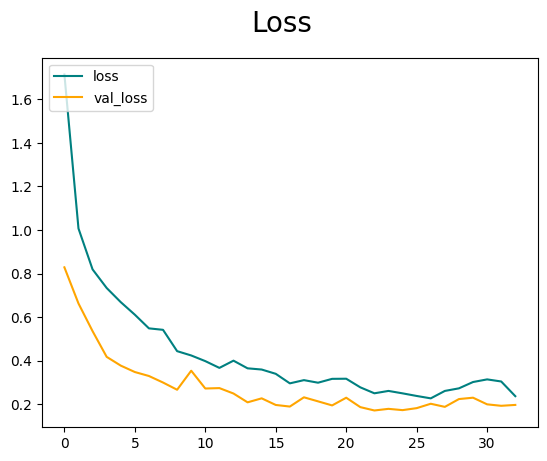

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

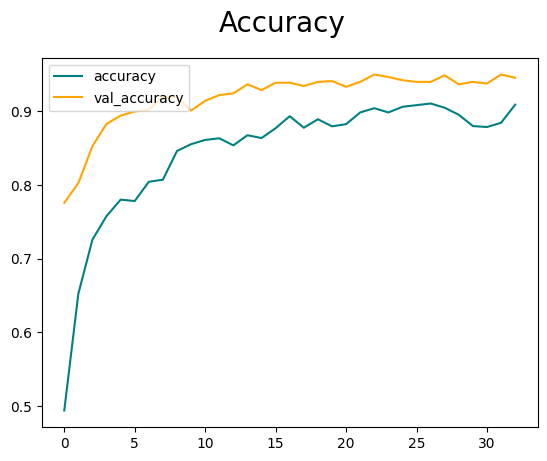

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 5.0 Evaluate

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [44]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 848ms/step


In [45]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:0.9330453276634216, Recall:0.9171974658966064, Accuracy: 0.9876149892807007


## 5.1 Predications

In [46]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [47]:
test_labels = y

In [48]:
len(test_labels)

23

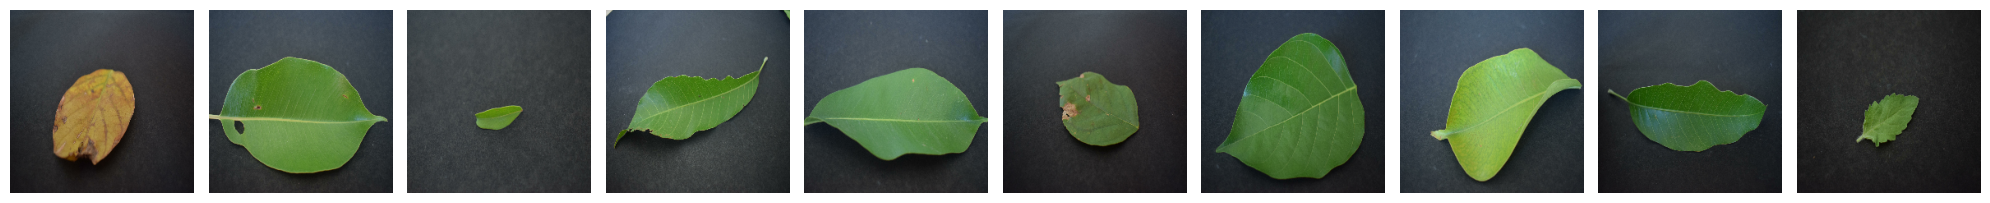

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [49]:
plotImages(X)
print(test_labels)

In [50]:
predictions = yhat

In [51]:
predictions

array([[2.48327799e-11, 1.88991010e-07, 1.44327612e-04, 1.99387046e-06,
        3.71728759e-09, 9.85065890e-06, 2.16379007e-07, 5.47336299e-07,
        6.01043985e-06, 1.10132064e-13, 4.68570849e-10, 9.99836922e-01],
       [1.28813635e-08, 2.65800866e-15, 7.13520744e-24, 6.45813109e-25,
        1.06769281e-19, 4.64314179e-18, 1.00000000e+00, 2.91617570e-25,
        5.07382547e-13, 1.53111888e-15, 2.09506936e-21, 8.19272705e-11],
       [7.39176385e-03, 6.90929517e-02, 2.44306489e-06, 3.77507305e-08,
        3.80958065e-09, 5.58101980e-04, 2.72124948e-04, 3.82904020e-08,
        1.86541554e-04, 1.47774947e-04, 9.22343194e-01, 4.92697745e-06],
       [1.18119214e-02, 4.97665678e-06, 3.09582008e-15, 5.54148648e-16,
        5.98412684e-15, 1.53678297e-08, 9.00246903e-07, 3.39891452e-14,
        2.31807662e-09, 9.88182127e-01, 3.78580223e-10, 9.54266333e-10],
       [8.55231716e-04, 1.81548410e-06, 2.97121659e-12, 1.81327663e-13,
        1.59841973e-10, 1.22262145e-09, 9.99141812e-01, 4.30

In [52]:

# Assuming your predictions are stored in the 'predictions' array
threshold = 0.5  # You can adjust this threshold as needed

# Convert probabilities to binary predictions based on the threshold
binary_predictions = np.where(predictions >= threshold, 1, 0)

In [53]:
binary_predictions

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0,

In [54]:
test_labels = np.array(test_labels)

In [55]:
test_labels

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.,

In [56]:
len(test_labels)

23

## 5.2 Confusion Matrix

In [57]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score
import seaborn as sns

In [58]:
cm = multilabel_confusion_matrix(test_labels, binary_predictions)

In [59]:
multilabel_cms = np.array(cm)

In [60]:
class_names

['Alstonia Scholaris (P2)',
 'Arjun (P1)',
 'Bael (P4)',
 'Basil (P8)',
 'Chinar (P11)',
 'Gauva (P3)',
 'Jamun (P5)',
 'Jatropha (P6)',
 'Lemon (P10)',
 'Mango (P0)',
 'Pomegranate (P9)',
 'Pongamia Pinnata (P7)']

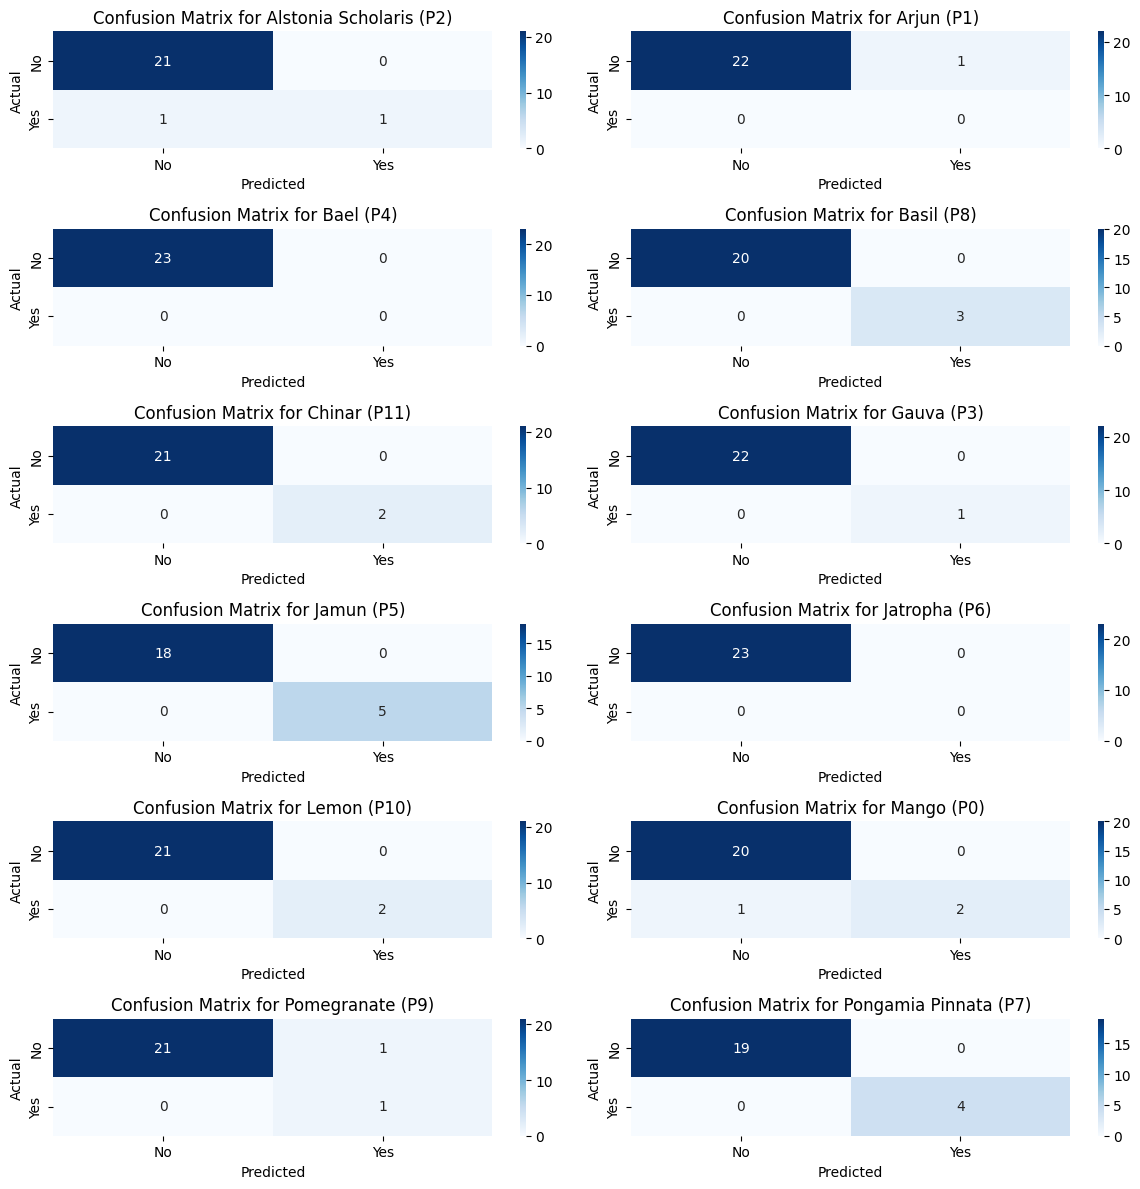

In [61]:
# Create a grid of subplots for each label
num_labels = len(class_names)
num_rows = (num_labels + 1) // 2  # Adjust the number of rows as needed
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 12))

# Flatten the axes array to handle cases where num_labels is odd
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_labels:
        conf_matrix = cm[i]
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=ax)
        ax.set_title(f"Confusion Matrix for {class_names[i]}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    else:
        fig.delaxes(ax)  # Remove any empty subplots

plt.tight_layout()
plt.show()

# 6.0 Test

In [189]:
import cv2
from matplotlib import pyplot as plt

TypeError: ignored

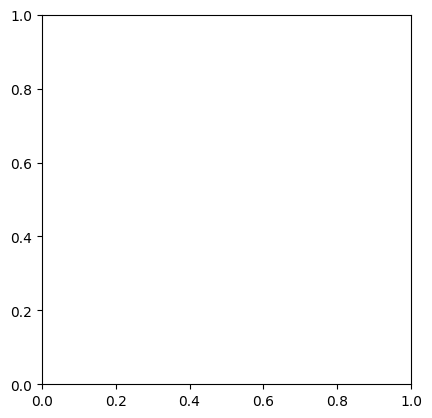

In [190]:
img = cv2.imread('healthy_test.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Unhealthy')
else:
    print(f'Predicted class is Healthy')

# 7.0 Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','leafhealth.h5'))

In [ ]:
new_model = load_model('models/leafhealth.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
#Verify that laoded model has the same achitecture and weights as the saved model
new_model.summary()

# 8.0 Augmentation

NEED TO ADJUST SO THAT WHEN RUN THROUGH ONCE IT AUGMENTS ALL THE DATA

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
chosen_image = random.choice(os.listdir('data/healthy'))

In [ ]:
image_path = 'data/healthy/' + chosen_image

In [ ]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True)

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [ ]:
plotImages(aug_images)

In [ ]:
aug_iter = gen.flow(image, save_to_dir='data/healthy', save_prefix='aug-image-', save_format='jpeg')